# Statistical analysis a and examples

In [1]:
import sys
sys.path.append('../common')
from utils import weight3 as weight_fn, weight_by_index
from utils import bag_weight, score, mean_n_sigma, score_stats
from utils import MAX_WEIGHT, AVAILABLE_GIFTS, GIFT_TYPES, N_TYPES, N_BAGS

from copy import deepcopy
from collections import defaultdict

import numpy as np
np.random.seed(2017)
import matplotlib.pyplot as plt
%matplotlib inline

Find optimal number of a single gift in the bag for a given rejection probability.

21
(957, 0.095699999999999993)
(21, 36.854131188127248, 368541.31188127247, 0.095699999999999993)
(22, 34.4924374896407, 344924.37489640701, 0.17630000000000001)
(20, 37.632215886726534, 376322.15886726533, 0.043700000000000003)
(19, 37.073197013856543, 370731.97013856546, 0.016500000000000001)


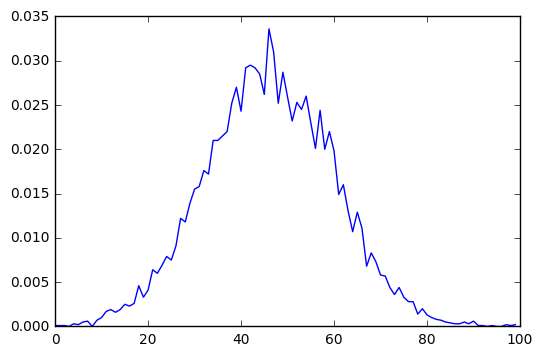

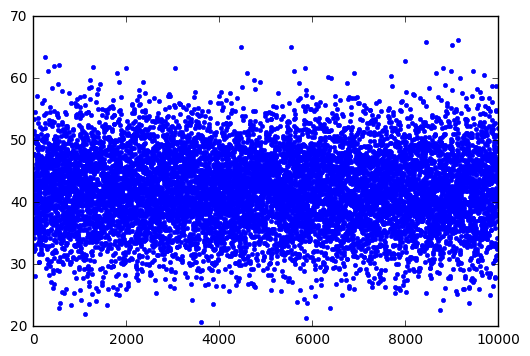

In [2]:
index = 0
weights = np.array([weight_by_index(index) for i in range(10000)])
hist = np.histogram(weights, bins=2*MAX_WEIGHT)

pdf = hist[0] *1.0 / np.sum(hist[0])
x = hist[1][:-1]

plt.figure()
plt.plot(pdf)

def find_n(pdf, x, epsilon=0.1):
    for n in range(1, 1000):
        y = MAX_WEIGHT * 1.0 / n
        res = np.where(x > y)[0]
        if len(res) > 0:
            index = res[0]
            pr = np.sum(pdf[index:])
            if pr > epsilon:
                return n-1
            
n = find_n(pdf, x, epsilon=0.1)
print(n)

print(np.sum(weights * n > MAX_WEIGHT), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

plt.figure()
plt.plot(weights * n, '.')


nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n += 1
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n -= 2
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

n -= 1
nweights = deepcopy(weights)
nweights[weights * n > MAX_WEIGHT] = 0.0
print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

Single gift optimization

In [3]:
N_TRIALS = 10000
GIFT_WEIGHTS = np.zeros((N_TRIALS, N_TYPES))
for index in range(N_TYPES):
    GIFT_WEIGHTS[:, index] = [weight_by_index(index) for i in range(10000)]

In [4]:
def find_n(weights):
    best_mean_score = 0
    best_n = 0
    for n in range(1, 500):
        mask = weights * n < MAX_WEIGHT
        if not mask.any():
            break
        score = np.sum(weights[mask] * n) * 1.0 / len(weights)  
        if score > best_mean_score:
            best_mean_score = score
            best_n = n
            
    return best_n, best_mean_score

LIMIT_NB_GIFTS = np.zeros((N_TYPES), dtype=np.uint8)

for index in range(N_TYPES):
    n, s = find_n(GIFT_WEIGHTS[:,index])
    print GIFT_TYPES[index], index, n, s
    LIMIT_NB_GIFTS[index] = n + 1


# print(np.sum(weights * n > MAX_WEIGHT), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n += 1
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n -= 2
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

# n -= 1
# nweights = deepcopy(weights)
# nweights[weights * n > MAX_WEIGHT] = 0.0
# print(n, np.sum(nweights * n) * 1.0 / len(nweights), np.sum(nweights * n), np.sum(weights * n > MAX_WEIGHT) * 1.0 / len(weights))

ball 0 20 37.4234804812
bike 1 2 20.894396983
blocks 2 3 31.035015986
book 3 14 14.8081476464
coal 4 1 23.3168017351
doll 5 6 25.1941147626
gloves 6 50 17.4548048468
horse 7 6 27.5209411252
train 8 3 24.8407205528


In [5]:
LIMIT_NB_GIFTS, np.prod(LIMIT_NB_GIFTS)

(array([21,  3,  4, 15,  2,  7, 51,  7,  4], dtype=uint8), 75569760)

## Multi-gift optimization

In [6]:
n_trials = 10000
weights = np.zeros((n_trials, N_TYPES))
for index in range(N_TYPES):
    weights[:, index] = [weight_by_index(index) for i in range(10000)]

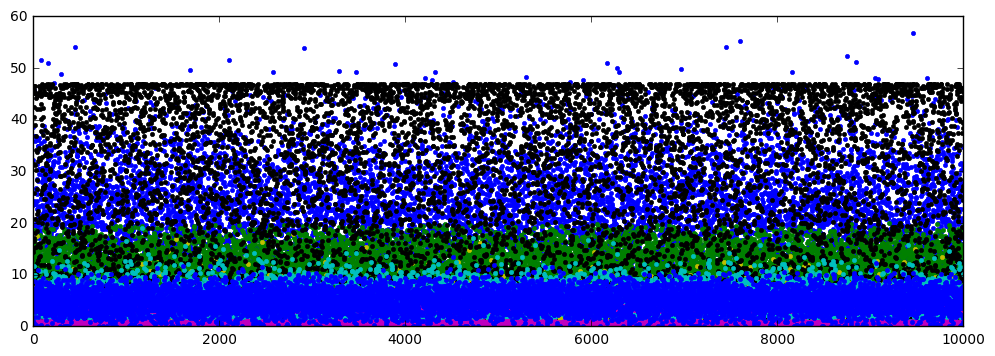

In [7]:
plt.figure(figsize=(12,4))    
colors = ['r','b','g','y','k','c','m','']
for index in range(N_TYPES-1):    
    plt.plot(weights[:, index], '.'+colors[index])

In [8]:
def compute_score(state):
    s = np.sum(GIFT_WEIGHTS * state, axis=1)
    mask = s < MAX_WEIGHT
    rejected = (N_TRIALS - np.sum(mask))*1.0 / N_TRIALS
    score = np.sum(s[mask]) * 1.0 / N_TRIALS
    return score, rejected


state = np.zeros((N_TYPES), dtype=np.uint8)
state[1] = 1
compute_score(state)

(20.129035166877681, 0.001)

In [9]:
alpha = 0.745
goal_weight = MAX_WEIGHT * alpha
print goal_weight

37.25


In [10]:
LIMIT_NB_GIFTS

array([21,  3,  4, 15,  2,  7, 51,  7,  4], dtype=uint8)

In [11]:
def huge_loop2(rejected_threshold):
    scores = []
    for n0 in range(LIMIT_NB_GIFTS[0]):
        print "n0: ", n0, "/", LIMIT_NB_GIFTS[0]
        state = np.array([n0, 0, 0, 0, 0, 0, 0, 0, 0])
        s, r = compute_score(state)
        if r > rejected_threshold:
            break
        for n1 in range(LIMIT_NB_GIFTS[1]):
            state = np.array([n0, n1, 0, 0, 0, 0, 0, 0, 0])
            s, r = compute_score(state)
            if r > rejected_threshold:
                break
            for n2 in range(LIMIT_NB_GIFTS[2]):
                state = np.array([n0, n1, n2, 0, 0, 0, 0, 0, 0])
                s, r = compute_score(state)
                if r > rejected_threshold:
                    break
                for n3 in range(LIMIT_NB_GIFTS[3]):
                    state = np.array([n0, n1, n2, n3, 0, 0, 0, 0, 0])
                    s, r = compute_score(state)
                    if r > rejected_threshold:
                        break
                    for n4 in range(LIMIT_NB_GIFTS[4]):
                        state = np.array([n0, n1, n2, n3, n4, 0, 0, 0, 0])
                        s, r = compute_score(state)
                        if r > rejected_threshold:
                            break                        
                        for n5 in range(LIMIT_NB_GIFTS[5]):
                            state = np.array([n0, n1, n2, n3, n4, n5, 0, 0, 0])
                            s, r = compute_score(state)
                            if r > rejected_threshold:
                                break                        
                            for n6 in range(LIMIT_NB_GIFTS[6]):
                                state = np.array([n0, n1, n2, n3, n4, n5, n6, 0, 0])
                                s, r = compute_score(state)
                                if r > rejected_threshold:
                                    break                        
                                for n7 in range(LIMIT_NB_GIFTS[7]):
                                    state = np.array([n0, n1, n2, n3, n4, n5, n6, n7, 0])
                                    s, r = compute_score(state)
                                    if r > rejected_threshold:
                                        break                        
                                    for n8 in range(LIMIT_NB_GIFTS[8]):
                                        state = np.array([n0, n1, n2, n3, n4, n5, n6, n7, n8])
                                        s, r = compute_score(state)
                                        if r > rejected_threshold:
                                            break                                    
                                        scores.append((state, s, r))
    return scores

In [13]:
scores = huge_loop2(0.75)

n0:  0 / 21
n0:  1 / 21
n0:  2 / 21
n0:  3 / 21
n0:  4 / 21
n0:  5 / 21
n0:  6 / 21
n0:  7 / 21
n0:  8 / 21
n0:  9 / 21
n0:  10 / 21
n0:  11 / 21
n0:  12 / 21
n0:  13 / 21
n0:  14 / 21
n0:  15 / 21
n0:  16 / 21
n0:  17 / 21
n0:  18 / 21
n0:  19 / 21
n0:  20 / 21


In [14]:
scores = np.array(scores)

In [15]:
alpha = 0.745
goal_weight = MAX_WEIGHT * alpha
print goal_weight

mask = scores[:, 1] > goal_weight
len(scores[mask]), scores[mask][:10, :]

37.25


(95, array([[array([6, 0, 1, 0, 0, 1, 1, 2, 0]), 37.369679272344804,
         0.053100000000000001],
        [array([7, 0, 1, 0, 0, 1, 0, 2, 0]), 37.527485719297054, 0.0613],
        [array([7, 0, 1, 1, 0, 1, 1, 1, 0]), 37.692940257865537, 0.0275],
        [array([7, 0, 1, 1, 0, 1, 2, 1, 0]), 37.344681205583392,
         0.060299999999999999],
        [array([8, 0, 1, 0, 0, 0, 1, 2, 0]), 37.552428587718268,
         0.030200000000000001],
        [array([8, 0, 1, 0, 0, 1, 1, 1, 0]), 38.087460032735109,
         0.020199999999999999],
        [array([8, 0, 1, 0, 0, 1, 2, 1, 0]), 37.604165717166701,
         0.055899999999999998],
        [array([8, 0, 1, 1, 0, 0, 0, 2, 0]), 37.423255074748297,
         0.043799999999999999],
        [array([8, 0, 1, 1, 0, 1, 0, 1, 0]), 37.992242875631888, 0.0332],
        [array([8, 0, 1, 1, 0, 1, 1, 1, 0]), 37.998889924227164,
         0.059499999999999997]], dtype=object))

In [16]:
# Save result
np.save("scores_r_075.npy", scores)

In [832]:
def has_min_nb_gifts(state):
    return np.sum(state) >= 3 

def is_available(state, available_gifts, gift_types=GIFT_TYPES):
    for v, gift_type in zip(state, gift_types):
        if available_gifts[gift_type] - v < 0:
            return False
    return True

def update_available_gifts(available_gifts, state, gift_types=GIFT_TYPES):
    for v, gift_type in zip(state, gift_types):
        assert available_gifts[gift_type] - v >= 0, "Found state is not available : {}, {}".format(state, available_gifts)
        available_gifts[gift_type] = available_gifts[gift_type] - v

        
def fill_bags(sorted_scores, available_gifts):
    filled_bags = np.zeros((N_BAGS, N_TYPES), dtype=np.uint8)    
    last_score_computation = -1
    good_bag_index = 0
    bag_index = 0
    while bag_index < N_BAGS and good_bag_index < len(sorted_scores):
    
        state = sorted_scores[good_bag_index, 0]
        if is_available(state, available_gifts) and has_min_nb_gifts(state):
            # print "bag index : ", bag_index
            update_available_gifts(available_gifts, state, GIFT_TYPES)
            filled_bags[bag_index, :] = state
            bag_index += 1
            good_bag_index += 1
        else:
            good_bag_index += 1
                
        if bag_index > 0 and (bag_index % 100) == 0 and last_score_computation < bag_index:
            s, r = score(filled_bags, return_rejected=True)
            print(bag_index, ">>> Current score: ", s, s * N_BAGS *1.0 / bag_index, "rejected=", r)
            last_score_computation = bag_index

        if bag_index > 0 and (bag_index % 150) == 0 and last_score_computation < bag_index:
            print(bag_index, ">>> Currently available gifts : ", [(k, available_gifts[k]) for k in GIFT_TYPES])
            last_score_computation = bag_index
    
    print "good_bag_index", good_bag_index
    return filled_bags



def fill_bags2(sorted_scores, available_gifts, n_gloves=70):
    
    filled_bags = np.zeros((N_BAGS, N_TYPES), dtype=np.uint8)
    
    last_score_computation = -1
    good_bag_index = 0
    bag_index = 0
    
    n_coals = int(n_gloves * 0.5)
    available_gifts['gloves'] = AVAILABLE_GIFTS['gloves'] - n_gloves
    N_BAGS -= n_coals
    while bag_index < N_BAGS and good_bag_index < len(sorted_scores):
    
        state = sorted_scores[good_bag_index, 0]
        if is_available(state, available_gifts) and has_min_nb_gifts(state):
            # print "bag index : ", bag_index
            update_available_gifts(available_gifts, state, GIFT_TYPES)
            filled_bags[bag_index, :] = state
            bag_index += 1
        else:
            good_bag_index += 1
                
        if bag_index > 0 and (bag_index % 100) == 0 and last_score_computation < bag_index:
            s, r = score(filled_bags, return_rejected=True)
            print(bag_index, ">>> Current score: ", s, s * N_BAGS *1.0 / bag_index, "rejected=", r)
            last_score_computation = bag_index

        if bag_index > 0 and (bag_index % 150) == 0 and last_score_computation < bag_index:
            print(bag_index, ">>> Currently available gifts : ", [(k, available_gifts[k]) for k in GIFT_TYPES])
            last_score_computation = bag_index
    
    N_BAGS += n_coals
    available_gifts['gloves'] = n_gloves
    while bag_index < N_BAGS and good_bag_index < len(sorted_scores):
        state = np.array([0,0,0,0,1,0,2,0,0])
        if is_available(state, available_gifts) and has_min_nb_gifts(state):
            # print "bag index : ", bag_index
            update_available_gifts(available_gifts, state, GIFT_TYPES)
            filled_bags[bag_index, :] = state
            bag_index += 1
        else:
            good_bag_index += 1
                
        if bag_index > 0 and (bag_index % 100) == 0 and last_score_computation < bag_index:
            s, r = score(filled_bags, return_rejected=True)
            print(bag_index, ">>> Current score: ", s, s * N_BAGS *1.0 / bag_index, "rejected=", r)
            last_score_computation = bag_index

        if bag_index > 0 and (bag_index % 150) == 0 and last_score_computation < bag_index:
            print(bag_index, ">>> Currently available gifts : ", [(k, available_gifts[k]) for k in GIFT_TYPES])
            last_score_computation = bag_index
        
    return filled_bags

In [829]:
import pandas as pd
df_scores = pd.DataFrame(data=scores, columns=['state', 'score', 'rejected'])
df_scores.head()

,state,score,rejected
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 1]",9.96169,0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 2]",19.8436,0.0015
3,"[0, 0, 0, 0, 0, 0, 0, 0, 3]",24.8407,0.0882
4,"[0, 0, 0, 0, 0, 0, 0, 1, 0]",5.02266,0


In [831]:
df_sorted_scores = df_scores.sort_values(['score'], ascending=False)
df_sorted_scores

,state,score,rejected
482878,"[12, 0, 1, 0, 0, 0, 0, 1, 0]",38.7049,0.0383
482983,"[12, 0, 1, 0, 0, 1, 0, 0, 0]",38.4753,0.0426
475945,"[11, 0, 1, 0, 0, 0, 1, 1, 0]",38.4635,0.0316
454721,"[9, 0, 1, 0, 0, 1, 0, 1, 0]",38.4156,0.0253
454730,"[9, 0, 1, 0, 0, 1, 1, 1, 0]",38.4088,0.0521
466851,"[10, 0, 1, 0, 0, 1, 0, 1, 0]",38.3948,0.0637
492302,"[15, 0, 0, 0, 0, 1, 0, 1, 0]",38.3146,0.0328
476082,"[11, 0, 1, 0, 0, 1, 1, 0, 0]",38.298,0.0347
491702,"[14, 0, 1, 0, 0, 0, 1, 0, 0]",38.2893,0.0532
476210,"[11, 0, 1, 1, 0, 0, 0, 1, 0]",38.286,0.046


In [198]:
df_sorted_scores[df_sorted_scores['rejected'] < 0.2].head()

,state,score,rejected
496174,"[16, 0, 1, 0, 0, 0, 1, 0, 0]",34.394,0.1999
439577,"[8, 0, 1, 1, 0, 1, 0, 2, 0]",34.0106,0.1999
483386,"[12, 0, 1, 4, 0, 0, 0, 0, 0]",32.0555,0.1999
442361,"[8, 1, 0, 0, 0, 0, 0, 1, 0]",30.0279,0.1999
411591,"[7, 0, 0, 5, 0, 1, 2, 0, 1]",29.7743,0.1999


In [833]:
r = 100.0
print "\n\n--- Start bags filling with : r=", r
df = df_sorted_scores[df_sorted_scores['rejected'] < r]
print "\n---", df.shape, df.head()
available_gifts = deepcopy(AVAILABLE_GIFTS)
print "\n--------------\n"
filled_bags = fill_bags(df.as_matrix(), available_gifts)




--- Start bags filling with : r= 100.0

--- (499104, 3)                                state    score rejected
482878  [12, 0, 1, 0, 0, 0, 0, 1, 0]  38.7049   0.0383
482983  [12, 0, 1, 0, 0, 1, 0, 0, 0]  38.4753   0.0426
475945  [11, 0, 1, 0, 0, 0, 1, 1, 0]  38.4635   0.0316
454721   [9, 0, 1, 0, 0, 1, 0, 1, 0]  38.4156   0.0253
454730   [9, 0, 1, 0, 0, 1, 1, 1, 0]  38.4088   0.0521

--------------

(100, '>>> Current score: ', 3905.3921545592816, 39053.921545592813, 'rejected=', 1.8899999999999999)
(150, '>>> Currently available gifts : ', [('ball', 0), ('bike', 500), ('blocks', 862), ('book', 1119), ('coal', 166), ('doll', 886), ('gloves', 71), ('horse', 827), ('train', 972)])
(200, '>>> Current score: ', 7454.6409279934269, 37273.204639967138, 'rejected=', 5.4299999999999997)
(300, '>>> Current score: ', 10914.512678594725, 36381.708928649081, 'rejected=', 10.08)
(400, '>>> Current score: ', 14290.13547945445, 35725.338698636129, 'rejected=', 16.890000000000001)
(450, '>>> Current

In [208]:
print score(filled_bags, return_rejected=True), available_gifts

(33808.409322412219, 51.859999999999999) {'horse': 0, 'ball': 0, 'blocks': 1, 'doll': 0, 'train': 0, 'coal': 166, 'bike': 500, 'gloves': 0, 'book': 0}


In [480]:
# sorted_scores = scores[scores[:,1].argsort()][::-1]
sorted_scores = scores[scores[:,2].argsort()][::-1]

In [481]:
# # for r in [100, 0.5, 0.1, 0.075]:
for r in [0.25,]:
    print "\n\n--- Start bags filling with : r=", r
    mask = sorted_scores[:, 2] < r
    sorted_scores = sorted_scores[mask]
    print "\n---", len(sorted_scores), sorted_scores[:5, :]
    available_gifts = deepcopy(AVAILABLE_GIFTS)
    print "\n--------------\n"
    filled_bags = fill_bags(sorted_scores, available_gifts)

# r = 100.0
# print "\n\n--- Start bags filling with : r=", r
# mask = sorted_scores[:, 2] < r
# sorted_scores = sorted_scores[mask]
# print "\n---", len(sorted_scores), sorted_scores[:5, :]
# available_gifts = deepcopy(AVAILABLE_GIFTS)
# print "\n--------------\n"
# n_gloves = 30
# filled_bags = fill_bags2(sorted_scores, available_gifts, n_gloves=n_gloves)
# s, r = score(filled_bags, return_rejected=True)



--- Start bags filling with : r= 0.25

--- 29381 [[array([5, 0, 0, 4, 0, 2, 8, 0, 0]) 24.365234490270218 0.24990000000000001]
 [array([9, 0, 0, 2, 0, 0, 8, 1, 0]) 24.096884237805025 0.24990000000000001]
 [array([0, 0, 0, 7, 0, 3, 2, 0, 1]) 25.784282483913127 0.24990000000000001]
 [array([1, 0, 0, 8, 0, 1, 3, 1, 1]) 25.706162011290402 0.24990000000000001]
 [array([3, 1, 0, 0, 0, 0, 4, 2, 0]) 27.443142224024911 0.24990000000000001]]

--------------

(100, '>>> Current score: ', 3490.9790062386783, 34909.790062386783, 'rejected=', 11.130000000000001)
(150, '>>> Currently available gifts : ', [('ball', 870), ('bike', 500), ('blocks', 890), ('book', 0), ('coal', 166), ('doll', 905), ('gloves', 0), ('horse', 735), ('train', 1000)])
(200, '>>> Current score: ', 7061.4922983896149, 35307.461491948074, 'rejected=', 25.190000000000001)
(300, '>>> Current score: ', 10869.523336334478, 36231.744454448257, 'rejected=', 35.560000000000002)
(400, '>>> Current score: ', 14525.350441632057, 36313.376

In [482]:
s, r = score(filled_bags, return_rejected=True)
print s, r, available_gifts

31853.4230985 165.78 {'horse': 0, 'ball': 0, 'blocks': 242, 'doll': 0, 'train': 271, 'coal': 165, 'bike': 0, 'gloves': 0, 'book': 0}


In [483]:
s = filled_bags_score(filled_bags)
print s

34352.6270059


In [183]:
index = 4177
len(sorted_scores), sorted_scores[index:index+10,:]

(17154, array([[array([0, 0, 1, 0, 0, 0, 0, 1, 2]), 30.766818752280845,
         0.10639999999999999],
        [array([1, 0, 0, 3, 0, 1, 7, 2, 0]), 26.935687127362883,
         0.10639999999999999],
        [array([3, 0, 0, 7, 0, 0, 1, 0, 1]), 24.573018042740969,
         0.10639999999999999],
        [array([2, 0, 0, 8, 0, 0, 3, 1, 0]), 22.220900790013562,
         0.10639999999999999],
        [array([0, 0, 0, 0, 0, 3, 0, 0, 2]), 29.001747020829562,
         0.10639999999999999],
        [array([4, 0, 1, 4, 0, 2, 0, 0, 0]), 31.597504445164198,
         0.10639999999999999],
        [array([2, 0, 1, 6, 0, 0, 4, 0, 0]), 26.663574992594413,
         0.10639999999999999],
        [array([3, 1, 0, 0, 0, 2, 0, 0, 0]), 30.334842311902239,
         0.10639999999999999],
        [array([4, 0, 0, 4, 0, 1, 6, 1, 0]), 28.307690755624318,
         0.10630000000000001],
        [array([2, 0, 0, 6, 0, 3, 1, 0, 0]), 25.930920973525062,
         0.10630000000000001]], dtype=object))


DataFrame sorted by rejected, score
```
--- Start bags filling with : r= 0.25

--- (29381, 3)                               state    score rejected
455777  [9, 0, 1, 3, 0, 1, 0, 1, 0]   31.682   0.2499
139990  [1, 0, 1, 0, 0, 1, 6, 3, 0]  27.8728   0.2499
333369  [4, 1, 0, 2, 0, 0, 0, 0, 1]   27.805   0.2499
187966  [2, 0, 0, 3, 0, 3, 5, 2, 0]  27.5574   0.2499
286224  [3, 1, 0, 0, 0, 0, 4, 2, 0]  27.4431   0.2499

--------------

(100, '>>> Current score: ', 3438.6738941097719, 34386.738941097719, 'rejected=', 21.079999999999998)
(150, '>>> Currently available gifts : ', [('ball', 0), ('bike', 500), ('blocks', 876), ('book', 652), ('coal', 166), ('doll', 798), ('gloves', 136), ('horse', 872), ('train', 974)])
(200, '>>> Current score: ', 6734.7375971198908, 33673.687985599456, 'rejected=', 38.719999999999999)
(300, '>>> Current score: ', 10350.614337046916, 34502.047790156386, 'rejected=', 49.280000000000001)
(400, '>>> Current score: ', 14135.415243839814, 35338.538109599533, 'rejected=', 56.420000000000002)
(450, '>>> Currently available gifts : ', [('ball', 0), ('bike', 498), ('blocks', 647), ('book', 0), ('coal', 166), ('doll', 146), ('gloves', 0), ('horse', 5), ('train', 903)])
(500, '>>> Current score: ', 17503.225950293272, 35006.451900586544, 'rejected=', 70.849999999999994)
(600, '>>> Current score: ', 20317.480950626974, 33862.468251044957, 'rejected=', 94.810000000000002)
(700, '>>> Current score: ', 23152.618090846012, 33075.168701208589, 'rejected=', 119.08)
(750, '>>> Currently available gifts : ', [('ball', 0), ('bike', 224), ('blocks', 349), ('book', 0), ('coal', 164), ('doll', 0), ('gloves', 0), ('horse', 3), ('train', 629)])
(800, '>>> Current score: ', 26015.183002100643, 32518.978752625804, 'rejected=', 141.71000000000001)
(900, '>>> Current score: ', 28765.490440326415, 31961.656044807129, 'rejected=', 166.81999999999999)
(1000, '>>> Current score: ', 31661.723713082891, 31661.723713082891, 'rejected=', 184.53999999999999)
good_bag_index 18070
```

Sorted by rejected only
```
--- Start bags filling with : r= 0.25

--- 29381 [[array([5, 0, 0, 4, 0, 2, 8, 0, 0]) 24.365234490270218 0.24990000000000001]
 [array([9, 0, 0, 2, 0, 0, 8, 1, 0]) 24.096884237805025 0.24990000000000001]
 [array([0, 0, 0, 7, 0, 3, 2, 0, 1]) 25.784282483913127 0.24990000000000001]
 [array([1, 0, 0, 8, 0, 1, 3, 1, 1]) 25.706162011290402 0.24990000000000001]
 [array([3, 1, 0, 0, 0, 0, 4, 2, 0]) 27.443142224024911 0.24990000000000001]]

--------------

(100, '>>> Current score: ', 3496.1827749027543, 34961.827749027543, 'rejected=', 11.25)
(150, '>>> Currently available gifts : ', [('ball', 870), ('bike', 500), ('blocks', 890), ('book', 0), ('coal', 166), ('doll', 905), ('gloves', 0), ('horse', 735), ('train', 1000)])
(200, '>>> Current score: ', 7110.2849691938763, 35551.424845969384, 'rejected=', 24.32)
(300, '>>> Current score: ', 10818.925691880086, 36063.085639600286, 'rejected=', 36.189999999999998)
(400, '>>> Current score: ', 14455.476624671543, 36138.691561678861, 'rejected=', 46.109999999999999)
(450, '>>> Currently available gifts : ', [('ball', 0), ('bike', 473), ('blocks', 717), ('book', 0), ('coal', 165), ('doll', 2), ('gloves', 0), ('horse', 0), ('train', 973)])
(500, '>>> Current score: ', 17450.085277363727, 34900.170554727454, 'rejected=', 67.239999999999995)
(600, '>>> Current score: ', 20384.609298878531, 33974.348831464216, 'rejected=', 88.859999999999999)
(700, '>>> Current score: ', 23155.257848227586, 33078.939783182264, 'rejected=', 114.18000000000001)
(750, '>>> Currently available gifts : ', [('ball', 0), ('bike', 173), ('blocks', 417), ('book', 0), ('coal', 165), ('doll', 2), ('gloves', 0), ('horse', 0), ('train', 673)])
(800, '>>> Current score: ', 26072.893919747683, 32591.117399684605, 'rejected=', 135.65000000000001)
(900, '>>> Current score: ', 28852.265702817826, 32058.073003130914, 'rejected=', 161.15000000000001)
(1000, '>>> Current score: ', 31697.101549771894, 31697.101549771894, 'rejected=', 168.53999999999999)
good_bag_index 18069
```


In [175]:
# available_gifts = deepcopy(AVAILABLE_GIFTS)
# filled_bags = fill_bags(sorted_scores, available_gifts)

In [174]:
print score(filled_bags, return_rejected=True), available_gifts

(31688.911937001107, 169.44) {'horse': 0, 'ball': 0, 'blocks': 242, 'doll': 0, 'train': 271, 'coal': 165, 'bike': 0, 'gloves': 0, 'book': 0}


In [149]:
#filled_bags_0 = deepcopy(filled_bags) # n_gloves = 0
#filled_bags_1 = deepcopy(filled_bags) # n_gloves = 50
#filled_bags_2 = deepcopy(filled_bags) # n_gloves = 100
#filled_bags_3 = deepcopy(filled_bags) # n_gloves = 70
#filled_bags_4 = deepcopy(filled_bags) # n_gloves = 30

In [150]:
# # Mean score of 100 last bags
# n_bags = 100
# s = score(filled_bags_4[-n_bags:, :])
# print s/n_bags

# # Mean bag score of 30 bags with gloves/coal : 28.9143427245

28.9143427245


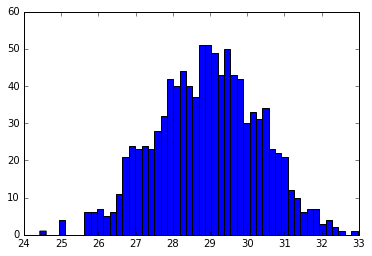

In [152]:
# # n_gloves = 30
# sc = np.zeros((1000))
# for i in range(1000):
#     s = 0
#     for state in filled_bags_4[-n_bags:, :]:
#         w = bag_weight(state, n1=1)
#         s += w if w < MAX_WEIGHT else 0
#     sc[i] = s/n_bags

# _ = plt.hist(sc, bins=MAX_WEIGHT)

In [145]:
# # Mean score of 100 last bags
# n_bags = 100
# s = score(filled_bags_3[-n_bags:, :])
# print s/n_bags

# # Mean bag score of 50 bags with gloves/coal : 27.7967959488

27.5297682481


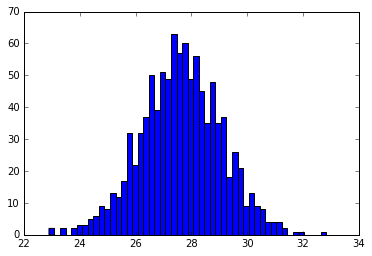

In [146]:
# # n_gloves = 70
# sc = np.zeros((1000))
# for i in range(1000):
#     s = 0
#     for state in filled_bags_3[-n_bags:, :]:
#         w = bag_weight(state, n1=1)
#         s += w if w < MAX_WEIGHT else 0
#     sc[i] = s/n_bags

# _ = plt.hist(sc, bins=MAX_WEIGHT)

In [134]:
# # Mean score of 100 last bags
# n_bags = 100
# s = score(filled_bags_2[-n_bags:, :])
# print s/n_bags

# # Mean bag score of 50 bags with gloves/coal : 26.7218278628

26.6894387245


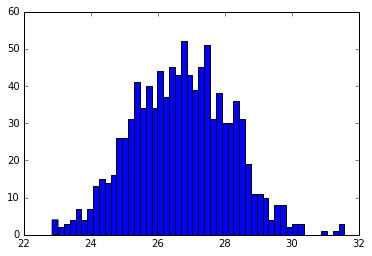

In [135]:
# # n_gloves = 100
# sc = np.zeros((1000))
# for i in range(1000):
#     s = 0
#     for state in filled_bags_2[-n_bags:, :]:
#         w = bag_weight(state, n1=1)
#         s += w if w < MAX_WEIGHT else 0
#     sc[i] = s/n_bags

# _ = plt.hist(sc, bins=MAX_WEIGHT)

In [63]:
# # Mean score of 100 last bags
# n_bags = 100
# s = score(filled_bags_1[-n_bags:, :])
# print s/n_bags

# # Mean bag score of 25 bags with gloves/coal : 28.2845131974

28.2845131974


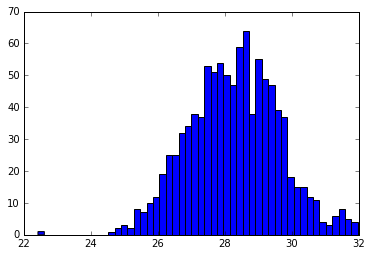

In [136]:
# # n_gloves = 50
# sc = np.zeros((1000))
# for i in range(1000):
#     s = 0
#     for state in filled_bags_1[-n_bags:, :]:
#         w = bag_weight(state, n1=1)
#         s += w if w < MAX_WEIGHT else 0
#     sc[i] = s/n_bags

# _ = plt.hist(sc, bins=MAX_WEIGHT)

In [60]:
# # Mean score of 100 last bags
# n_bags = 100
# s = score(filled_bags_0[-n_bags:, :])
# print s/n_bags

# # Mean bag score without gloves/coal : 29.7704966655

29.7704966655


In [173]:
# # n_gloves = 0
# sc = np.zeros((1000))
# for i in range(1000):
#     s = 0
#     for state in filled_bags_0[-n_bags:, :]:
#         w = bag_weight(state, n1=1)
#         s += w if w < MAX_WEIGHT else 0
#     sc[i] = s/n_bags

# _ = plt.hist(sc, bins=MAX_WEIGHT)

(23.088245759383238, 0.057700000000000001) (23.087111470586706, 0.059999999999999998)


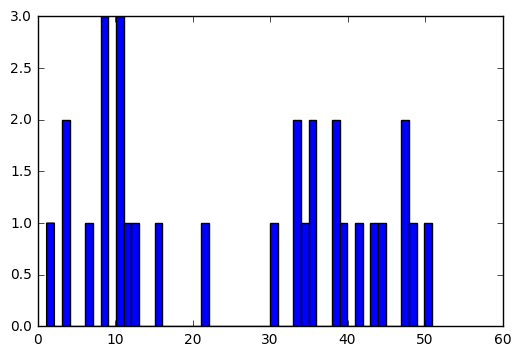

In [351]:
# gloves_coal_state = np.array([0,0,0,0,1,0,2,0,0])
# print compute_score(gloves_coal_state), score((gloves_coal_state,), return_rejected=True)
# weights = np.array([bag_weight(gloves_coal_state, n1=1) for i in range(30)])
# _ = plt.hist(weights, bins=MAX_WEIGHT)

In [154]:
def to_submission(state, available_gifts, gift_types):
    n_gifts = [available_gifts[t] for t in gift_types]
    output = []
    for bag in state:
        o = []
        for index, count in enumerate(bag):   
            gift_type = gift_types[index]
            for i in range(count):
                v = n_gifts[index] - 1
                assert v >= 0, "Gift index is negative"
                o.append(gift_type + '_%i' % v)
                n_gifts[index] -= 1
        output.append(o)  
    return output

def write_submission(state, filename):
    with open(filename, 'w') as w:
        w.write("Gifts\n")
        for bag in state:
            w.write(' '.join(bag) + '\n')
    


In [828]:
from datetime import datetime
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'  
        
submission = to_submission(filled_bags, AVAILABLE_GIFTS, GIFT_TYPES)    
write_submission(submission, submission_file)        

### Some results 

- submission_2017-01-27-15-51.csv
- 1000 max scores
- Local : 34722.394251084297
- Kaggle: 35143.27282


- submission_2017-01-27-16-00.csv
- 1000 max scores
- rejected = 0.075
- Local : 31405.637035241478
- Kaggle : 31645.38768


- submission_2017-01-27-16-36.csv
- 900 max scores
- n_gloves = 200
- Local : 34083
- Kaggle : 34040.37733


- submission_2017-01-28-01-42.csv
- 975 max scores
- n_gloves = 30
- Local : 34604.652758133743
- Kaggle : 35044.53273


- submission_2017-01-28-14-00.csv
- Sort decreasing 'rejected', 0.25
- Local : 31688
- Kaggle : 32222.66426


- submission_2017-01-28-14-52.csv
- Sort decreasing 'rejected', 'score': rejected=0.17
- Local : 33820.373412003297, 51.950000000000003
- Kaggle : 


- submission_2017-01-29-13-22.csv
- Sort decreasing 'pr_wins', source 'scores' with rejected=0.25
- Local : 33963.264414211175, 49.600000000000001
- Kaggle : 34122.79829



(23.292749557837666, 0.076999999999999999) (23.668996625806241, 0.080000000000000002)


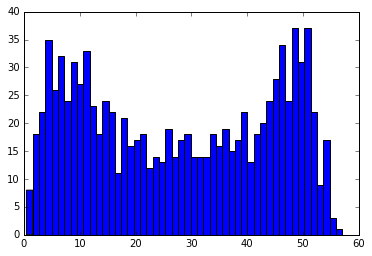

In [511]:
gloves_coal_state = np.array([0,0,0,0,1,0,3,0,0])
print compute_score(gloves_coal_state), score((gloves_coal_state,), return_rejected=True)
weights = np.array([bag_weight(gloves_coal_state, n1=1) for i in range(1000)])
_ = plt.hist(weights, bins=MAX_WEIGHT)

(31.681979585950682, 0.24990000000000001) (33.492158295016736, 0.22)


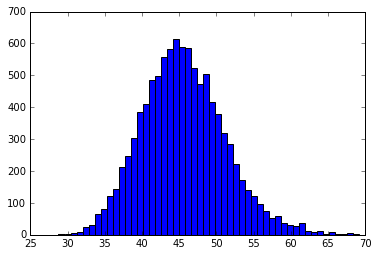

In [292]:
state = np.array([9, 0, 1, 3, 0, 1, 0, 1, 0])
print compute_score(state), score((state,), return_rejected=True)
weights = np.array([bag_weight(state, n1=1) for i in range(10000)])
hist = plt.hist(weights, bins=MAX_WEIGHT)

In [259]:
pdf = hist[0] *1.0 / np.sum(hist[0])
x = hist[1][:-1]
pr_lose = np.sum(pdf[np.where(x > MAX_WEIGHT)])
pr_win = np.sum(pdf[np.where((x < MAX_WEIGHT) & (x > 33.0))])

In [260]:
pr_lose, pr_win

(0.17500000000000002, 0.81699999999999995)

33.9261621734 0.0058


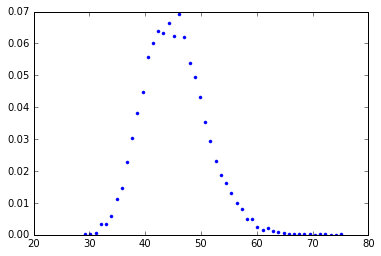

In [263]:
print x[5], pdf[5]
plt.plot(x, pdf, '.')

In [356]:
state = np.array([9, 0, 1, 3, 0, 1, 0, 1, 0])
n_bags = 1000
print compute_score(state), score((state,), return_rejected=True)
weights = np.array([bag_weight(state, n1=1) for i in range(n_bags)])
weights[weights > MAX_WEIGHT] = 0.0

m = compute_score(state)[0]
n_wins = np.sum(weights > m) * 1.0 / n_bags
m_wins = np.mean(weights[weights > m])
n_loses = np.sum(weights < m) * 1.0 / n_bags
m_loses = np.mean(weights[weights < m])
nm = m_wins * n_wins + m_loses * n_loses
print n_wins, n_loses, m, nm, m_wins, m_loses

(31.681979585950682, 0.24990000000000001) (33.869934700111706, 0.22)
0.801 0.199 31.681979586 34.9531011523 43.5979996429 0.156298684969


In [360]:
hist = np.histogram(weights, bins=MAX_WEIGHT)
pdf = hist[0] *1.0 / np.sum(hist[0])
x = hist[1][:-1]

mean_weight = np.sum(x * pdf)
print mean_weight

34.5625573955


In [646]:
n_bags = 1000
%time w = np.array([bag_weight(state, n1=1) for i in range(n_bags)])

CPU times: user 219 ms, sys: 1.73 ms, total: 221 ms
Wall time: 219 ms


In [816]:
def bag_weight2(state):
    w = 0 
    ll = GIFT_WEIGHTS.shape[0]
    for i, v in enumerate(state):
        if v > 0:
            start = np.random.randint(ll)
            end = (start + v) % ll
            w += np.sum(GIFT_WEIGHTS[start:end,i])
    return w

bag_weight2(state), bag_weight(state)

(46.774919018939599, 46.243259839541381)

In [817]:
def proba_win(state, n_bags=100):
    weights = np.array([bag_weight2(state) for i in range(n_bags)])
    weights[weights > MAX_WEIGHT] = 0.0
    m = compute_score(state)[0]
    n_wins = np.sum(weights > m) * 1.0 / n_bags
    return n_wins

In [818]:
%time proba_win(state)

CPU times: user 5.36 ms, sys: 1.75 ms, total: 7.11 ms
Wall time: 5.63 ms


0.73999999999999999

In [819]:
state, proba_win(state)

(array([9, 0, 1, 3, 0, 1, 0, 1, 0]), 0.83999999999999997)

In [820]:
proba_win_vec = np.vectorize(proba_win)

In [821]:
sorted_scores_pr_wins = np.zeros((sorted_scores.shape[0]))
sorted_scores_pr_wins[:] = proba_win_vec(sorted_scores[:, 0])

In [822]:
df1 = pd.DataFrame(sorted_scores, columns=['state', 'score', 'rejected'])
df2 = pd.DataFrame(sorted_scores_pr_wins, columns=['pr_wins'])
df = pd.concat([df1, df2], axis=1)

In [823]:
df3 = df.sort_values(['pr_wins', 'score'], ascending=False)
df3.head(10)

,state,score,rejected,pr_wins
19147,"[19, 0, 0, 0, 0, 0, 2, 0, 0]",36.7782,0.0757,1.0
13571,"[20, 0, 0, 0, 0, 0, 2, 0, 0]",35.4917,0.1363,1.0
13351,"[19, 0, 0, 1, 0, 0, 2, 0, 0]",35.3584,0.1384,1.0
12954,"[19, 0, 0, 0, 0, 0, 3, 0, 0]",34.5317,0.1425,1.0
4981,"[20, 0, 0, 0, 0, 0, 3, 0, 0]",32.5471,0.214,1.0
13333,"[15, 0, 0, 1, 0, 0, 5, 0, 0]",31.533,0.1386,1.0
11101,"[14, 0, 0, 0, 0, 0, 5, 1, 0]",31.3275,0.161,1.0
9783,"[14, 0, 0, 1, 0, 0, 6, 0, 0]",29.005,0.1731,1.0
7959,"[7, 0, 1, 0, 0, 1, 6, 0, 0]",28.8222,0.1891,1.0
7457,"[8, 0, 0, 0, 0, 0, 6, 3, 0]",28.6764,0.1935,1.0


In [824]:
df3['pr_wins'].unique()

array([ 1.  ,  0.99,  0.98,  0.97,  0.96,  0.95,  0.94,  0.93,  0.92,
        0.91,  0.9 ,  0.89,  0.88,  0.87,  0.86,  0.85,  0.84,  0.83,
        0.82,  0.81,  0.8 ,  0.79,  0.78,  0.77,  0.76,  0.75,  0.74,
        0.73,  0.72,  0.71,  0.7 ,  0.69,  0.68,  0.67,  0.66,  0.65,
        0.64,  0.63,  0.62,  0.61,  0.6 ,  0.59,  0.58,  0.57,  0.56,
        0.55,  0.54,  0.53,  0.52,  0.51,  0.5 ,  0.49,  0.48,  0.47,
        0.46,  0.45,  0.44,  0.43,  0.42,  0.41,  0.4 ,  0.39,  0.38,
        0.37,  0.36,  0.35,  0.34,  0.33,  0.32,  0.31,  0.3 ,  0.29,
        0.26,  0.25,  0.  ])

In [826]:
print "\n\n--- Start bags filling with"
print "\n---", df3.shape, df3.head()
available_gifts = deepcopy(AVAILABLE_GIFTS)
print "\n--------------\n"
filled_bags = fill_bags(df3.as_matrix(), available_gifts)




--- Start bags filling with

--- (29381, 4)                               state    score rejected  pr_wins
19147  [19, 0, 0, 0, 0, 0, 2, 0, 0]  36.7782   0.0757      1.0
13571  [20, 0, 0, 0, 0, 0, 2, 0, 0]  35.4917   0.1363      1.0
13351  [19, 0, 0, 1, 0, 0, 2, 0, 0]  35.3584   0.1384      1.0
12954  [19, 0, 0, 0, 0, 0, 3, 0, 0]  34.5317   0.1425      1.0
4981   [20, 0, 0, 0, 0, 0, 3, 0, 0]  32.5471    0.214      1.0

--------------

(100, '>>> Current score: ', 3719.816070928945, 37198.160709289456, 'rejected=', 1.0800000000000001)
(150, '>>> Currently available gifts : ', [('ball', 0), ('bike', 500), ('blocks', 999), ('book', 35), ('coal', 166), ('doll', 971), ('gloves', 0), ('horse', 909), ('train', 1000)])
(200, '>>> Current score: ', 7172.1331633258797, 35860.6658166294, 'rejected=', 5.8700000000000001)
(300, '>>> Current score: ', 10971.847219889582, 36572.824066298606, 'rejected=', 13.15)
(400, '>>> Current score: ', 14635.231771478411, 36588.07942869603, 'rejected=', 18.8599

In [827]:
print score(filled_bags, return_rejected=True), available_gifts

(33963.264414211175, 49.600000000000001) {'horse': 0, 'ball': 0, 'blocks': 0, 'doll': 0, 'train': 0, 'coal': 166, 'bike': 499, 'gloves': 0, 'book': 0}


In [581]:
df_sorted_scores_2 = df_scores.sort_values(['score', 'rejected'], ascending=False)

In [772]:
df_sorted_scores_2.shape

(499104, 3)

In [771]:
df_sorted_scores_2.loc[index100, 'n_loses'] = 1 - df_sorted_scores_2.loc[index100, 'n_wins']

KeyError: 'the label [n_wins] is not in the [columns]'

In [770]:
df = df_sorted_scores_2.sort_values('n_wins', ascending=False)
df.head()

KeyError: 'n_wins'

In [525]:
def state_score(state):
    n_bags = 1000
    s, r = compute_score(state)
    weights = np.array([bag_weight(state, n1=1) for i in range(n_bags)])
    weights[weights > MAX_WEIGHT] = 0.0
    hist = np.histogram(weights, bins=MAX_WEIGHT)
    pdf = hist[0] *1.0 / np.sum(hist[0])
    x = hist[1][:-1]
    return np.sum(x * pdf)


def filled_bags_score(bags):
    s = 0
    for bag in bags:
        s += bag_weight(state, n1=1)
    return s

gloves_coal_state = np.array([0,0,0,0,1,0,2,0,0])
print state, state_score(state), score((state,), return_rejected=True) 
print gloves_coal_state, state_score(gloves_coal_state), score((gloves_coal_state,), return_rejected=True) 
print win_lose(state), win_lose(gloves_coal_state)

[9 0 1 3 0 1 0 1 0] 33.800795035 (33.153464007741277, 0.23999999999999999)
[0 0 0 0 1 0 2 0 0] 23.4492374717 (22.731160986729527, 0.050000000000000003)
(0.79700000000000004, 0.20300000000000001) (0.46100000000000002, 0.53900000000000003)


In [579]:
print win_lose(state), win_lose(gloves_coal_state) 
print proba_win(state, 100), proba_win(gloves_coal_state, 100)

[0.78900000000000003, 0.21099999999999999] [0.50700000000000001, 0.49299999999999999]
0.77 0.5


In [489]:
def filled_bags_score(bags, n1=1):
    out = []
    for i in range(5):
        s = 0
        for bag in bags:
            w = bag_weight(state, n1)
            s += w if w < MAX_WEIGHT else 0
        out.append(s)
    return out

s = filled_bags_score(filled_bags)
print s

[38273.398959407576, 38497.113252422285, 38107.391973547179, 38486.38332110217, 39256.486555697971]


In [498]:
filled_bags[0], filled_bags[24]

(array([5, 0, 0, 4, 0, 2, 8, 0, 0], dtype=uint8),
 array([5, 0, 0, 4, 0, 2, 8, 0, 0], dtype=uint8))

In [501]:
25 * 8

200

In [499]:
AVAILABLE_GIFTS

{'ball': 1100,
 'bike': 500,
 'blocks': 1000,
 'book': 1200,
 'coal': 166,
 'doll': 1000,
 'gloves': 200,
 'horse': 1000,
 'train': 1000}

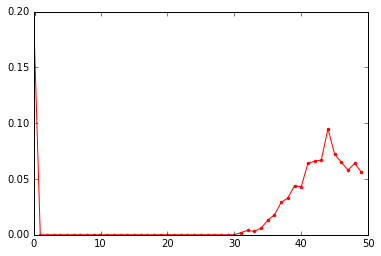

In [363]:
plt.plot(x, pdf, '.-r')